#Previsão de Receita estimada (USD)
Iniciamos carregando as biliotecas necessárias.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

##Carregamento do dataset
Fazemos o carregamento e verificação do conteúdo do dataset.

In [ ]:
data_views = pd.read_csv("view_data.csv")
data_views.head()

,Data,Visualizações,Tempo de exibição (horas),Duração média da visualização,Receita estimada (USD)
0,Total,1468526,95496.3714,0:03:54,1404.421
1,2023-12,11134,791.0265,0:04:15,8.169
2,2023-11,26850,1905.9733,0:04:15,26.242
3,2023-10,25822,1761.2078,0:04:05,21.679
4,2023-09,27996,1925.5687,0:04:07,22.644


Excluiremos a primeira linha, preencheremos dados nulos e converteremos o campo de data para o formato datetime.

In [ ]:
data_views = data_views.drop(index = 0)

In [ ]:
data_views['Receita estimada (USD)'].fillna(0,inplace = True)

In [ ]:
data_views['Data'] = pd.to_datetime(data_views['Data'])

Organizaremos o dataframe por ordem de data.

In [ ]:
data_views = data_views.sort_values(by='Data', ascending = True)
data_views

,Data,Visualizações,Tempo de exibição (horas),Duração média da visualização,Receita estimada (USD)
91,2016-06-01,230,10.1095,0:02:38,0.000
90,2016-07-01,220,6.8727,0:01:52,0.000
89,2016-08-01,979,37.5707,0:02:18,0.000
88,2016-09-01,1338,53.7578,0:02:24,0.000
87,2016-10-01,1029,42.0026,0:02:26,0.000
...,...,...,...,...,...
5,2023-08-01,28737,1940.2318,0:04:03,25.148
4,2023-09-01,27996,1925.5687,0:04:07,22.644
3,2023-10-01,25822,1761.2078,0:04:05,21.679
2,2023-11-01,26850,1905.9733,0:04:15,26.242


Iniciamos então a previsão utilizando ARIMA. O código em Python realiza a validação cruzada de séries temporais usando a técnica TimeSeriesSplit. Utilizando a biblioteca pmdarima, o código treina e avalia um modelo ARIMA automaticamente ajustando seus parâmetros em cada fold. As métricas de desempenho (MAE, MSE, RMSE) são calculadas e armazenadas, além de plotar um gráfico comparativo entre as séries temporais reais e previstas. O resultado final exibe as médias das métricas. Este processo proporciona uma avaliação robusta do modelo ao longo do tempo.

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
 

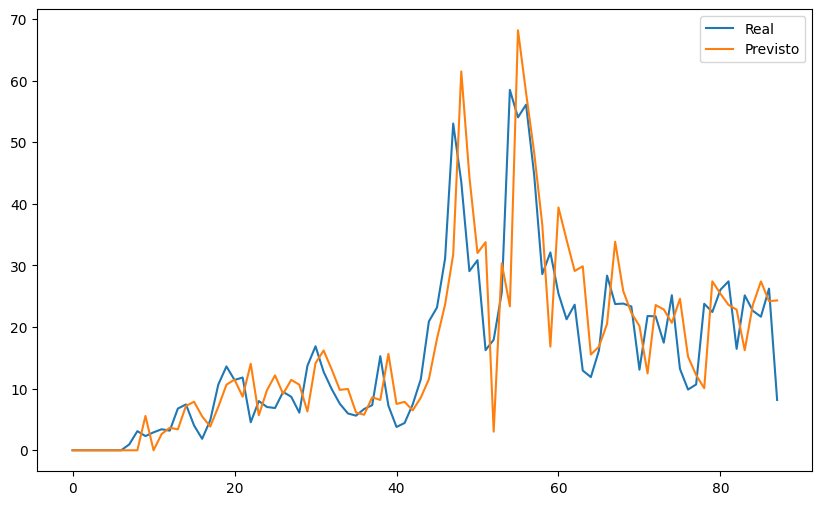

Média MAE: 5.570759440427245
Média MSE: 66.6399152751656
Média RMSE: 5.570759440427245


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds
tss_2 = TimeSeriesSplit(n_splits= 88)

# Listas para armazenar resultados
mae_list, mse_list, rmse_list = [], [], []
y_teste_list, y_pred_list = [], []

# Iteração sobre os folds
fold = 0
for i_train, i_test in tss_2.split(data_views):
    fold += 1
    train, test = data_views.iloc[i_train], data_views.iloc[i_test]

    # Normalização usando MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train['Receita estimada (USD)'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['Receita estimada (USD)'].values.reshape(-1, 1))

    # Treinar o modelo ARIMA com parâmetros ajustados
    model = auto_arima(train_scaled, suppress_warnings=True, seasonal=False, stepwise=False, trace=False, error_action='ignore', maxiter=99)

    # Ajustar o modelo ARIMA com os melhores parâmetros encontrados
    fit_model = model.fit(train_scaled)

    # Realizar previsões
    y_pred_scaled = fit_model.predict(n_periods=len(test_scaled))

    # Desnormalização
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de Receita estimada (USD) não sejam negativos
    y_pred = np.maximum(y_pred, 0)

    # Calcular métricas
    mae = mean_absolute_error(test['Receita estimada (USD)'], y_pred)
    mse = mean_squared_error(test['Receita estimada (USD)'], y_pred)
    rmse = sqrt(mse)

    # Armazenar resultados
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    y_teste_list.extend(test['Receita estimada (USD)'])
    y_pred_list.extend(y_pred)

# Médias das métricas
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

# Plotar resultado final
plt.figure(figsize=(10, 6))
plt.plot(y_teste_list, label='Real')
plt.plot(y_pred_list, label='Previsto')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

# Resultados finais
print(f'Média MAE: {mean_mae}')
print(f'Média MSE: {mean_mse}')
print(f'Média RMSE: {mean_rmse}')

Podemos justificar a utilização de uma grande quantidade de folds pela necessidade de capturar a dinâmica temporal dos dados, que é complexa e, tomando dados mensais, conta com apenas 92 amostras.

## Previsão para os próximos 12 meses
Aqui o processo é repetido, porém agregando a previsão para os próximo ano.

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
 

Previsões futuras médias para os próximos 12 meses:
[16.54898325 17.0482915  17.68277766 18.37507366 18.78389349 19.06199461
 19.242556   19.46239197 19.71183729 20.01115176 20.39941589 20.83613737]


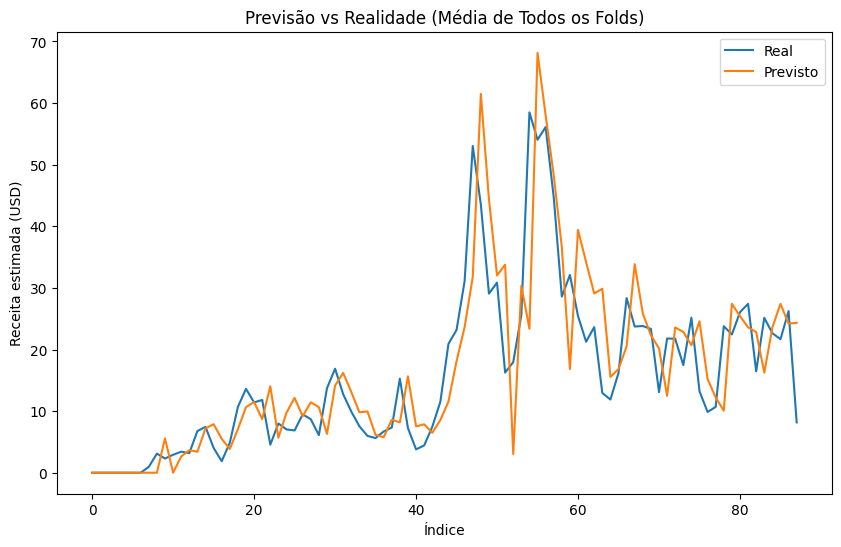

Média MAE: 5.570759440427245
Média MSE: 66.6399152751656
Média RMSE: 5.570759440427245


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds
tss_2 = TimeSeriesSplit(n_splits= 88)

# Listas para armazenar resultados
mae_list, mse_list, rmse_list = [], [], []
y_teste_list, y_pred_list = [], []

# Previsões futuras
future_pred_list = []

# Iteração sobre os folds
fold = 0
for i_train, i_test in tss_2.split(data_views):
    fold += 1
    train, test = data_views.iloc[i_train], data_views.iloc[i_test]

    # Normalização usando MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train['Receita estimada (USD)'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['Receita estimada (USD)'].values.reshape(-1, 1))

    # Treinar o modelo ARIMA com parâmetros ajustados
    model = auto_arima(train_scaled, suppress_warnings=True, seasonal=False, stepwise=False, trace=False, error_action='ignore', maxiter=99)

    # Ajustar o modelo ARIMA com os melhores parâmetros encontrados
    fit_model = model.fit(train_scaled)

    # Realizar previsões
    y_pred_scaled = fit_model.predict(n_periods=len(test_scaled))

    # Desnormalização
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de Receita estimada (USD) não sejam negativos
    y_pred = np.maximum(y_pred, 0)

    # Calcular métricas
    mae = mean_absolute_error(test['Receita estimada (USD)'], y_pred)
    mse = mean_squared_error(test['Receita estimada (USD)'], y_pred)
    rmse = sqrt(mse)

    # Armazenar resultados
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    y_teste_list.extend(test['Receita estimada (USD)'])
    y_pred_list.extend(y_pred)

    # Estender o treinamento para incluir dados de teste
    train_test_combined = np.concatenate((train_scaled, test_scaled))
    fit_model = model.fit(train_test_combined)

    # Fazer previsões para os próximos 12 meses (altere conforme necessário)
    future_periods = 12
    future_pred_scaled = fit_model.predict(n_periods=future_periods)

    # Desnormalização das previsões futuras
    future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de Receita estimada (USD) não sejam negativos
    future_pred = np.maximum(future_pred, 0)

    # Armazenar previsões futuras
    future_pred_list.append(future_pred)

# Calcular a média das previsões futuras
mean_future_pred = np.mean(future_pred_list, axis=0)

# Imprimir as previsões futuras médias
print(f"Previsões futuras médias para os próximos {future_periods} meses:")
print(mean_future_pred)

# Médias das métricas
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

# Plotar resultado final
plt.figure(figsize=(10, 6))
plt.plot(y_teste_list, label='Real')
plt.plot(y_pred_list, label='Previsto')
plt.title('Previsão vs Realidade (Média de Todos os Folds)')
plt.xlabel('Índice')
plt.ylabel('Receita estimada (USD)')
plt.legend()
plt.show()

# Resultados finais
print(f'Média MAE: {mean_mae}')
print(f'Média MSE: {mean_mse}')
print(f'Média RMSE: {mean_rmse}')

Abaixo vemos a lista dos valores preditos e o plot das receitas para 2024.

In [ ]:
mean_future_pred

array([16.54898325, 17.0482915 , 17.68277766, 18.37507366, 18.78389349,
       19.06199461, 19.242556  , 19.46239197, 19.71183729, 20.01115176,
       20.39941589, 20.83613737])

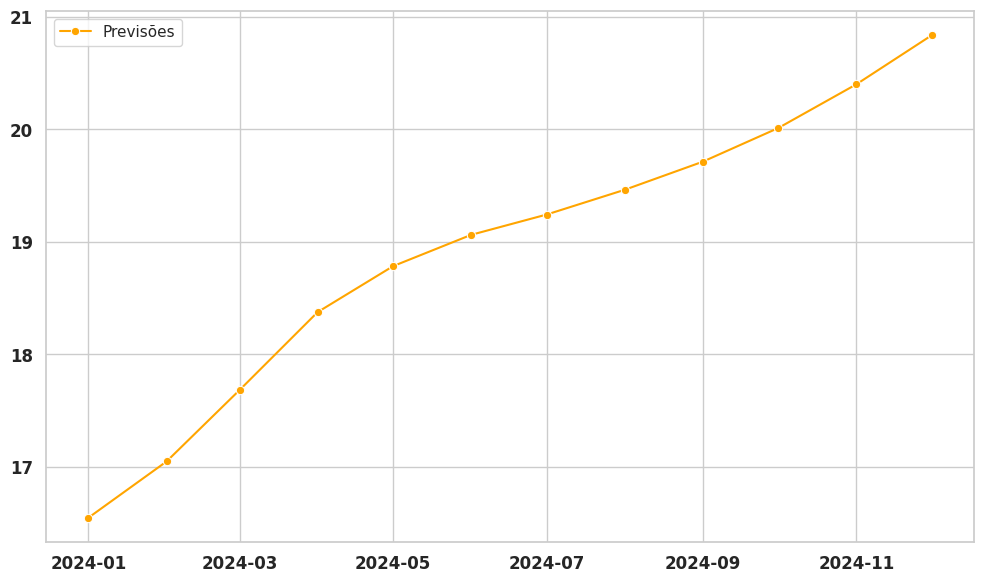

In [ ]:
import seaborn as sns

# Criar um DataFrame com os dados
df = pd.DataFrame({
    'Meses': pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS'),
    'Previsões': mean_future_pred
})

# Configurar o estilo do seaborn
sns.set(style='whitegrid')

# Criar o lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Meses', y='Previsões', data=df, marker='o', color='orange', label='Previsões')

# Adicionar rótulos e título
plt.xlabel('')
plt.ylabel('')
plt.title('')

# Ajustar o tamanho e a negrito dos ticks no eixo x e y
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12
, fontweight='bold')

# Exibir o gráfico
plt.xticks(rotation= 0)
plt.tight_layout()
plt.show()